In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,learning_curve

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

In [243]:
df = pd.read_csv('../data/data_clear.csv')

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881197 entries, 0 to 881196
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   City            881197 non-null  object 
 1   State           881197 non-null  object 
 2   BankState       881197 non-null  object 
 3   Term            881197 non-null  float64
 4   NoEmp           881197 non-null  float64
 5   NewExist        881197 non-null  object 
 6   CreateJob       881197 non-null  int64  
 7   RetainedJob     881197 non-null  int64  
 8   UrbanRural      881197 non-null  object 
 9   RevLineCr       881197 non-null  int64  
 10  LowDoc          881197 non-null  int64  
 11  GrAppv          881197 non-null  float64
 12  is_default      881197 non-null  int64  
 13  have_franchise  881197 non-null  int64  
 14  sector          881197 non-null  object 
 15  in_recession    881197 non-null  int64  
dtypes: float64(3), int64(7), object(6)
memory usage: 107.6+ 

In [245]:
df.head()

,City,State,BankState,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,GrAppv,is_default,have_franchise,sector,in_recession
0,EVANSVILLE,IN,OH,84.0,4.0,New,0,0,Undefined,0,1,60000.0,0,0,Retail trade,0
1,NEW PARIS,IN,IN,60.0,2.0,New,0,0,Undefined,0,1,40000.0,0,0,Accommodation and food services,0
2,BLOOMINGTON,IN,IN,180.0,7.0,Existing,0,0,Undefined,0,0,287000.0,0,0,Health care and social assistance,0
3,BROKEN ARROW,OK,OK,60.0,2.0,Existing,0,0,Undefined,0,1,35000.0,0,0,Sector not known,0
4,ORLANDO,FL,FL,240.0,14.0,Existing,7,7,Undefined,0,0,229000.0,0,0,Sector not known,0


In [246]:
df.columns

Index(['City', 'State', 'BankState', 'Term', 'NoEmp', 'NewExist', 'CreateJob',
       'RetainedJob', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv',
       'is_default', 'have_franchise', 'sector', 'in_recession'],
      dtype='object')

In [247]:
X = df.drop(['City', 'CreateJob','RetainedJob', 'RevLineCr',"is_default"], axis=1)
y = df['is_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True,stratify=y, random_state=42)

In [248]:
numeric_features = ["Term","NoEmp","GrAppv"]
categorial_features = ["State","BankState", "LowDoc","NewExist","UrbanRural","sector", 'have_franchise', 'in_recession']

In [249]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [250]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features)
    ]
   , remainder="passthrough" 
)

In [251]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
pipe_dummy = Pipeline([
     ('preprocessor', preprocessor),
     ('dummy', dummy)
])

In [252]:
len(y_train)

793077

In [253]:
len(y_test)

88120

In [254]:
pipe_dummy.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'LowDoc', 'NewExist',
                                                   'UrbanRural', 'sector',
                                                   'have_franchise',
                                                   'in_recession'])])),
                ('dummy', DummyClassifier())])

In [255]:
print(pipe_dummy.score(X_train,y_train))
print(pipe_dummy.score(X_test,y_test))

0.8257205794645412
0.8257262823422605


In [256]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
tree = RandomForestClassifier(n_estimators=51,min_samples_split=100,random_state=42,oob_score=True,class_weight={0: 1, 1: 2.25},verbose=2,n_jobs=4,max_samples=0.8)

In [257]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('decisiontree', tree)
])

In [258]:
pipe.fit(X_train,y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 51
building tree 2 of 51
building tree 3 of 51
building tree 4 of 51
building tree 5 of 51
building tree 6 of 51
building tree 7 of 51
building tree 8 of 51
building tree 9 of 51
building tree 10 of 51
building tree 11 of 51
building tree 12 of 51
building tree 13 of 51
building tree 14 of 51
building tree 15 of 51
building tree 16 of 51
building tree 17 of 51
building tree 18 of 51
building tree 19 of 51
building tree 20 of 51
building tree 21 of 51
building tree 22 of 51
building tree 23 of 51
building tree 24 of 51
building tree 25 of 51
building tree 26 of 51
building tree 27 of 51
building tree 28 of 51
building tree 29 of 51
building tree 30 of 51
building tree 31 of 51
building tree 32 of 51
building tree 33 of 51
building tree 34 of 51
building tree 35 of 51
building tree 36 of 51
building tree 37 of 51


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.7min


building tree 38 of 51
building tree 39 of 51
building tree 40 of 51
building tree 41 of 51
building tree 42 of 51
building tree 43 of 51
building tree 44 of 51
building tree 45 of 51
building tree 46 of 51
building tree 47 of 51
building tree 48 of 51
building tree 49 of 51
building tree 50 of 51
building tree 51 of 51


[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:  5.1min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'LowDoc', 'NewExist',
                                                   'UrbanRural', 'sector',
                                                   'have_franchise',
                                                   'in_recession'])])),
                ('decisiontree',
                 RandomForestClassifier(class_weight={0: 1, 1: 2.25},
                                        max_samples=0.8, min_samples_split=100,
                                        n_estimators=51, n_jobs=4,
                                        oob_score=True, random_state=42,
                                        verbose=2))])

In [259]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


0.9337453992487489
0.9263731275533363


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    0.4s finished


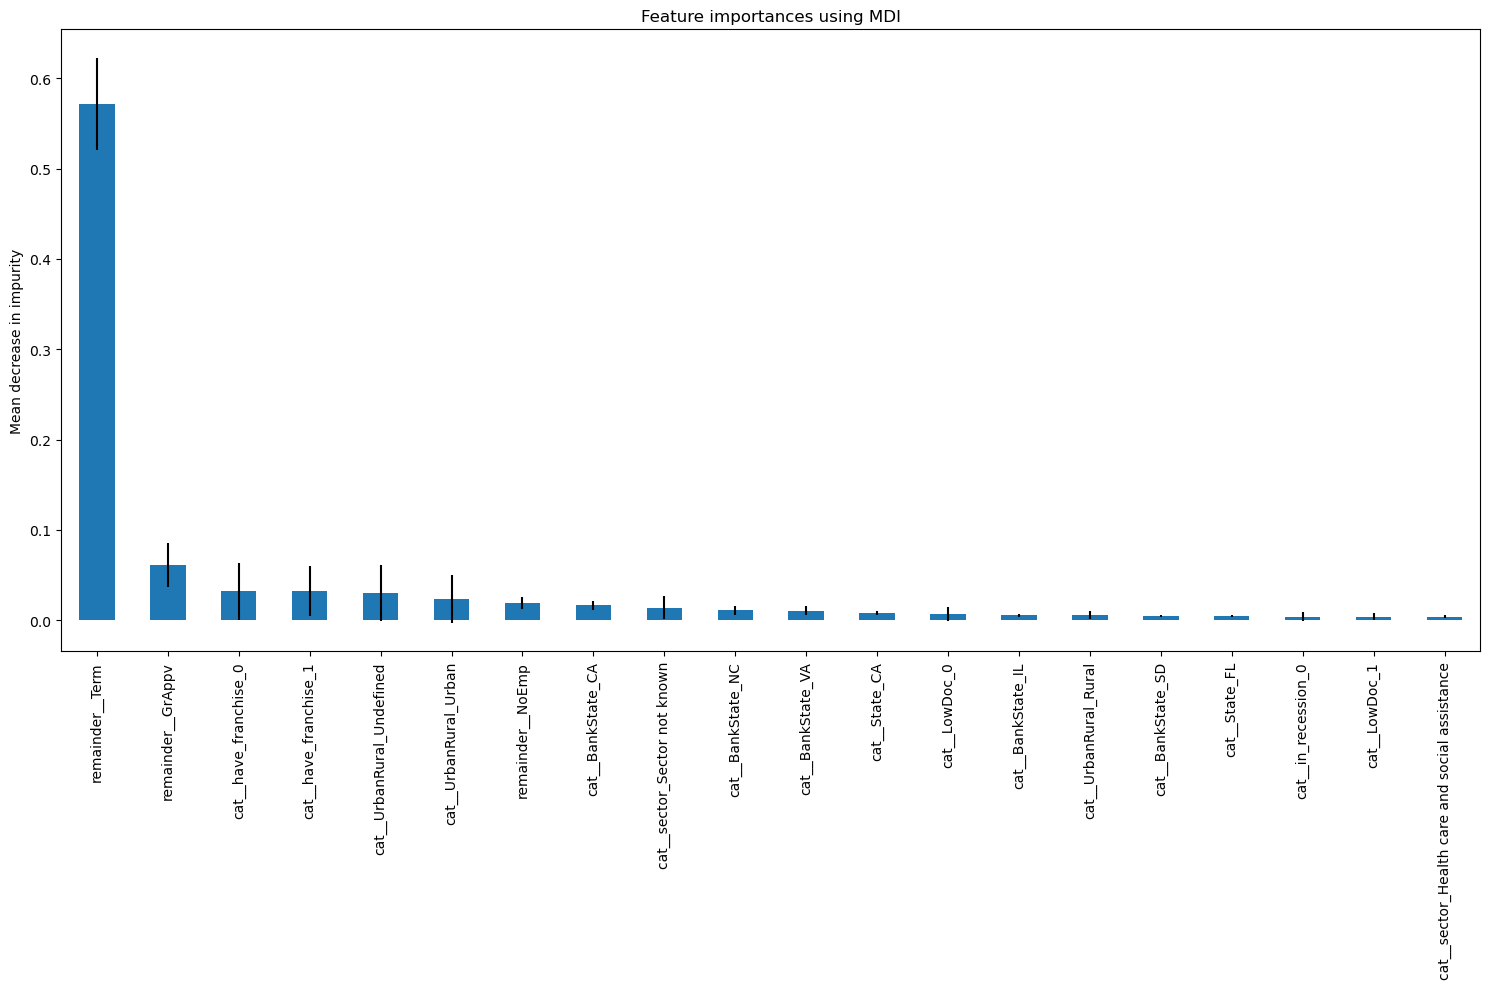

In [260]:
importances = pipe[-1].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe[-1].estimators_], axis=0)

forest_importances = pd.DataFrame({"feature_importances":importances,"std":std},index=pipe[0].get_feature_names_out())
forest_importances.sort_values(by="feature_importances",ascending=False,inplace=True)
forest_importances = forest_importances.head(20)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances["feature_importances"].plot.bar(yerr=forest_importances["std"], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [261]:
pipe[-1].oob_score_

0.9243755650460169

In [262]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_train,y_pred=pipe.predict(X_train)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    3.0s finished


              precision    recall  f1-score   support

           0       0.96      0.96      0.96    654860
           1       0.81      0.81      0.81    138217

    accuracy                           0.93    793077
   macro avg       0.89      0.88      0.88    793077
weighted avg       0.93      0.93      0.93    793077



In [263]:
print(classification_report(y_true=y_test,y_pred=pipe.predict(X_test)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    0.3s finished


              precision    recall  f1-score   support

           0       0.95      0.96      0.96     72763
           1       0.79      0.79      0.79     15357

    accuracy                           0.93     88120
   macro avg       0.87      0.87      0.87     88120
weighted avg       0.93      0.93      0.93     88120



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    2.8s finished


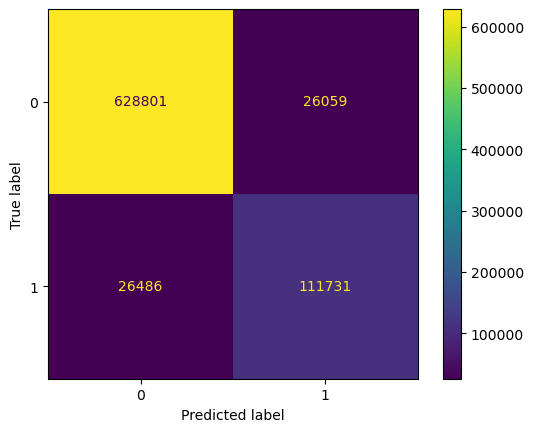

In [264]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=y_train,y_pred=pipe.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe[-1].classes_)
disp.plot()

plt.show()


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    0.4s finished


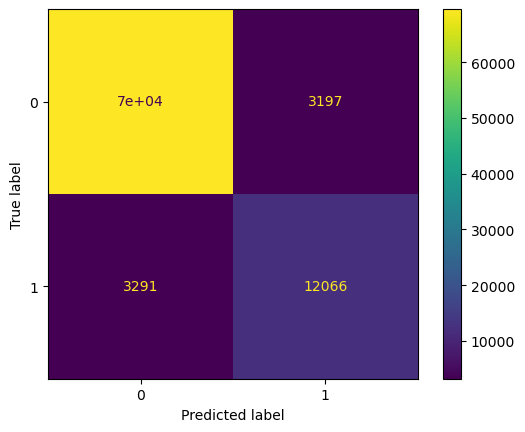

In [265]:
cm = confusion_matrix(y_true=y_test,y_pred=pipe.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe[-1].classes_)
disp.plot()

plt.show()


In [266]:
# train_sizes, train_scores, test_scores = learning_curve(pipe,X_train,y_train,cv=3,train_sizes=np.linspace(0.1, 1.0, 50))                                    
                                           
# plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
# plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
# plt.xlabel('train_sizes')
# plt.legend()
# plt.show()

In [267]:
# from sklearn import tree
# import graphviz 

# dot_data = tree.export_graphviz(pipe[-1].estimators_[0],out_file=None, 
#                      feature_names=new_columns,  
#                       filled=True, rounded=True,
#                       class_names=["False","True"],
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph.render("model_test",format="pdf")
# graph

# LogisticRegression

In [268]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', categorical_transformer, categorial_features),
#         ("num",StandardScaler(),numeric_features)
#         ]
# )

# logisticreg=Pipeline([
#      ('preprocessor', preprocessor),
#      ('logisticregression', LogisticRegression(random_state=42,max_iter=10000))
#      ]
# )


In [269]:
# logisticreg.fit(X_train,y_train)

In [270]:
# from sklearn.inspection import permutation_importance


# result = permutation_importance(logisticreg, X_train, y_train, n_repeats=10,
#                                 random_state=0)
# result.importances_mean

# result.importances_std

In [271]:
# col_name = logisticreg[0].get_feature_names_out()

# coef = pd.DataFrame(data=logisticreg[-1].coef_.reshape(-1,1), columns=['coefs'], index=col_name)

In [272]:
# coef = coef.sort_values(by="coefs",ascending=False)
# coef.head(30)

In [273]:
# print(logisticreg.score(X_train,y_train))
# print(logisticreg.score(X_test,y_test))